In [1]:
from scipy.sparse import dok_matrix
import sys
sys.path.insert(0, "../farkas-tool")
from dtmc import DTMC, ReducedDTMC

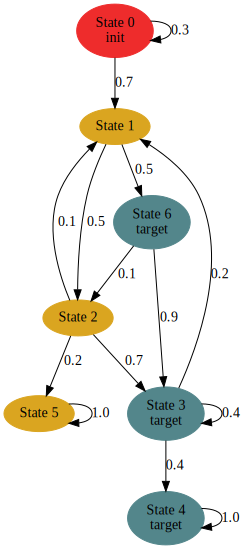

In [2]:
# create simple 7x7 transition matrix
P = dok_matrix((7,7))
P[0,0], P[0,1] = 0.3, 0.7
P[1,2], P[1,6] = 0.5, 0.5
P[2,1], P[2,3], P[2,5] = 0.1, 0.7, 0.2
P[3,1], P[3,3], P[3,4] = 0.2, 0.4, 0.4
P[4,4] = 1
P[5,5] = 1
P[6,3], P[6,2] = 0.9, 0.1

# create the markov chain
labels = {    "target" : set({3,4,6}),
              "init" : set({0}) }
mc = DTMC(P, labels)
mc.graphviz_digraph()

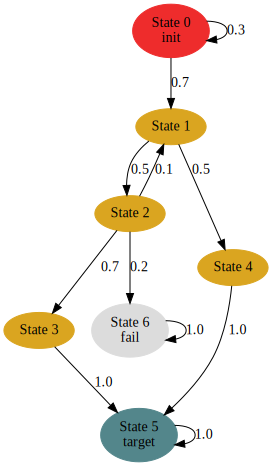

In [3]:
mc_reduced, full_to_reduced, reduced_to_full = mc.reduce("init", "target")
mc_reduced = mc_reduced.as_dtmc()
mc_reduced.graphviz_digraph()

## Basics for reduced DTMCs
If a (reduced) DTMC is created from a given transition matrix P, a set of target states and some initial state, it will do a search for all states that are able to reach the target state(s) (backwards search) and are reachable from the initial state (forwards search). States which do not fulfill these conditions are removed and replaced by a single "fail"-state. Also, all target states get re-wired to a single target state with probability 1. If a target state is only reachable by other target states, it will get removed. These actions may decrease the amount of states and re-index the state indices. The re-indexing is given by a dictionary which maps new state indices to old ones.

For example, consider the (reduced) DTMC as given above. The target states got replaced by a new target state ("new" index 5) and all previous target states (in this case with "new" indices 3 and 4) get re-wired to 5 with probability 1. Mind that although there were originally three target states, only two were considered for re-wiring. This is because the "old" target state 4 has nothing but other target states as predecessors and is therefore redundant (see transition matrix in second cell). "old" state 5 is not able to reach any target state and is therefore removed and replaced by "new" state 6 (fail state).

Calling `graphviz_digraph` creates a `graphviz.Digraph` object (requires the python3 graphviz package) which can be exported as a svg, pdf or (for example) png file. It is possible to customize the function, as can be seen in the cell below.

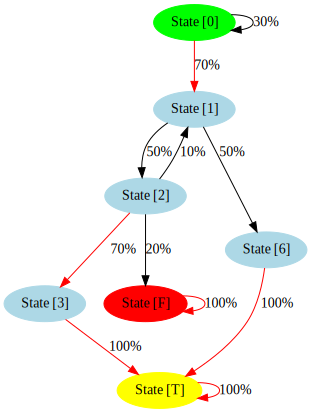

In [4]:
def custom_state_map(stateidx, labels):
    global reduced_to_full
    # by using the mapping, we can find out the "old" state index given the "new" state index 
    label = "State [%s]" % reduced_to_full[stateidx]
    
    # see https://www.graphviz.org/doc/info/colors.html for all possible colors
    color = "lightblue"
    if "init" in labels:
        color = "green"
    elif "target" in labels:
        color = "yellow"
    elif "fail" in labels:
        color = "red"
    
    return {  "label" : label,
              "color" : color,
              "enable" : True }
        
def custom_transition_map(sourceidx, destidx, sourcelabels, destlabels, p):
    return { "label" : "%d%%" % round(p*100),
             "color" : "red" if p > 0.6 else "black",
             "enable" : True }
    
mc_reduced.graphviz_digraph( state_map=custom_state_map, 
                             trans_map=custom_transition_map)

## Parametrization of Graph-Rendering
`graphviz_digraph` takes a set of different parameters which make it possible to customize the resulting digraph-object. This includes a way of coloring and naming states as well as transitions (`state_color_map`, `state_label_map`, `trans_color_map` and `trans_label_map`). The default setting for the target state is to be separated.

`state_color_map` and `state_label_map` are given by functions which output a color or a label based on a given state index (the "new" state index) and flags which give information on if the state is target, fail or initial (or neither). `trans_color_map` and `trans_label_map` work analogous for transitions and take the source state index, destination state index and the respective probability into account.

saved at datasets/toy.tra, datasets/toy.lab


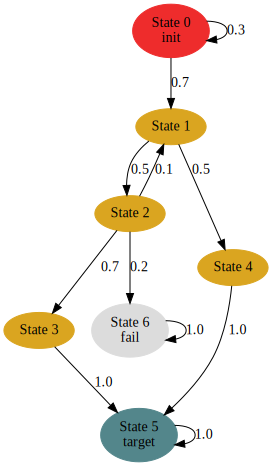

In [5]:
tra_path, lab_path = mc_reduced.save("datasets/toy")
print("saved at %s, %s" % (tra_path, lab_path))
mc_loaded = DTMC.from_file(lab_path, tra_path)
mc_loaded.graphviz_digraph()

## Saving and Loading
It is possible to save and load a reduced DTMC from and to a .tra and .lab-file. For further information see https://www.prismmodelchecker.org/manual/Appendices/ExplicitModelFiles. Mind that the mapping from "new" to "old" state indices gets lost after saving and restoring the DTMCs.